# Прогнозирование температуры звезды

Задание разработать метод определения температуры на поверхности звёзд с использованием нейросетей. Вместо традиционных методов, таких как закон смещения Вина, закон Стефана-Больцмана и спектральный анализ, обсерватория решила внедрить технологии машинного обучения для более точного и удобного прогнозирования температуры звёзд. Для этого доступны характеристики 240 изученных звёзд в базе данных обсерватории.                  

# План по выполнению проекта
1. Загрузка данных
2. Предобработка и анализ данных
3. Построение базовой нейронной сети
4. Улучшение нейронной сети
5. Выводы по проекту

# Описание данных

- **/datasets/6_class.csv** - ссылка на данные

**Признаки**

- **Luminosity(L/Lo)** — относительная светимость: светимость звезды относительно Солнца.
- **Radius(R/Ro)** — относительный радиус: радиус звезды относительно радиуса Солнца.
- **Absolute magnitude(Mv)** — абсолютная звёздная величина: физическая величина, характеризующая блеск звезды.
- **Star color** — цвет звезды (white, red, blue, yellow, yellow-orange и др.), который определяют на основе спектрального анализа.
- **Star type** — тип звезды. Номер, соответствующий типу:
     - Коричневый карлик	0
     - Красный карлик	1
     - Белый карлик	2
     - Звёзды главной последовательности	3
     - Сверхгигант	4
     - Гипергигант	5

**Целевой признак**

- **Temperature (K)** — абсолютная температура T(K), температура на поверхности звезды в Кельвинах

💡 **Справочная информация:**
 
 
Светимость Солнца (англ. Average Luminosity of Sun): $$L_0 = 3.828 \times 10^{26} \, \text{Вт}$$
 
Радиус Солнца (англ. Average Radius of Sun): $$R^{}_0 = 6.9551⋅10^8 м$$

## Загрузка данных

### Импорт библиотек, создание функций

In [1]:
!pip install -q sweetviz
!pip install -q imblearn

In [2]:
import warnings
warnings.filterwarnings('ignore')

#загрузка данных
import os

#загрузка стандартных библиотек
import pandas as pd
import numpy as np

#для работы с регулярными выражениями
import re

#графики
import seaborn as sns
from matplotlib import pyplot as plt

#генерация отчетов с визуализацией для выполнения EDA
import sweetviz as sv

#подготовка к созданию нейронной сети 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

#создание нейронной сети: 
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

In [3]:
# Информация о данных:
def info(data):
    '''
    1. Вывод информации о данных
    2. Вывод первых пяти строк данных с полным выводом всех столбцов
    3. Вывод сводной статистики
    '''
    data.info()
    pd.set_option('display.max_columns', None)
    display(data.head())
    #сводная статистика данных
    display(data.describe())
    pass

In [4]:
# Построение столбчатой диаграммы для значений столбца:
def plot_column_distribution(df, column_name, xlabel, title):
    # Подсчет количества значений для указанного столбца и сортировка по убыванию
    column_counts = df[column_name].value_counts(dropna=False).sort_values(ascending=False)

    # Расчет процентного содержания
    total_count = len(df[column_name])
    percentages = [(count / total_count) * 100 for count in column_counts]

    # Создание столбчатой диаграммы с процентами
    plt.figure(figsize=(12, 5))
    bars = plt.bar(column_counts.index.astype(str), column_counts, color='skyblue')  # Преобразование индекса в строки

    for bar, percentage in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')
        
    plt.xticks(rotation=15)
    plt.xlabel(xlabel)
    plt.ylabel('Количество')
    plt.title(title)
    plt.show()

In [5]:
# График "Факт-Прогноз"
def predictions_graph(y_pred):
    start = 0
    end = 26
    
    basic_df = y_test[start:end]
    nn_df = y_pred[start:end]

    plt.figure(figsize=(15, 8))
    plt.bar(range(start, end), nn_df.detach().numpy(), color='lightblue', label='Прогноз')
    plt.bar(range(start, end), basic_df, color='orange', width=0.5, label='Факт')

    plt.legend()
    plt.title('Факт-Прогноз')
    plt.xlabel('Номер звезды в таблице данных')
    plt.ylabel('Температура звезды')
    plt.show()

### Загрузка данных

In [6]:
link1 = '/datasets/6_class.csv'
link2 = 'другая ссылка'

if os.path.exists(link1):
    data = pd.read_csv(link1) 
elif os.path.exists(pth2):
    query_1 = pd.read_csv(link2)
else:
    print('Cсылки не действительна')

In [7]:
data.to_csv('data.csv', index=False)

## Предобработка и анализ данных

In [8]:
info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


                                             |          | [  0%]   00:00 -> (? left)


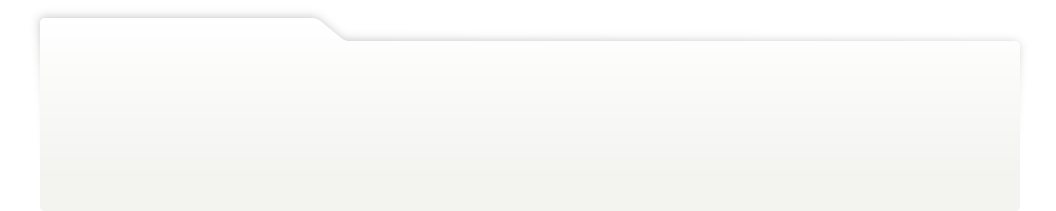
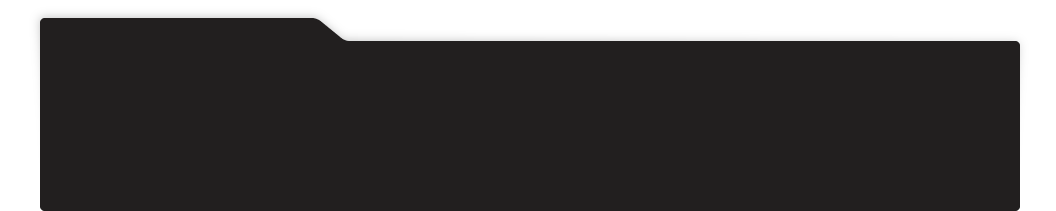
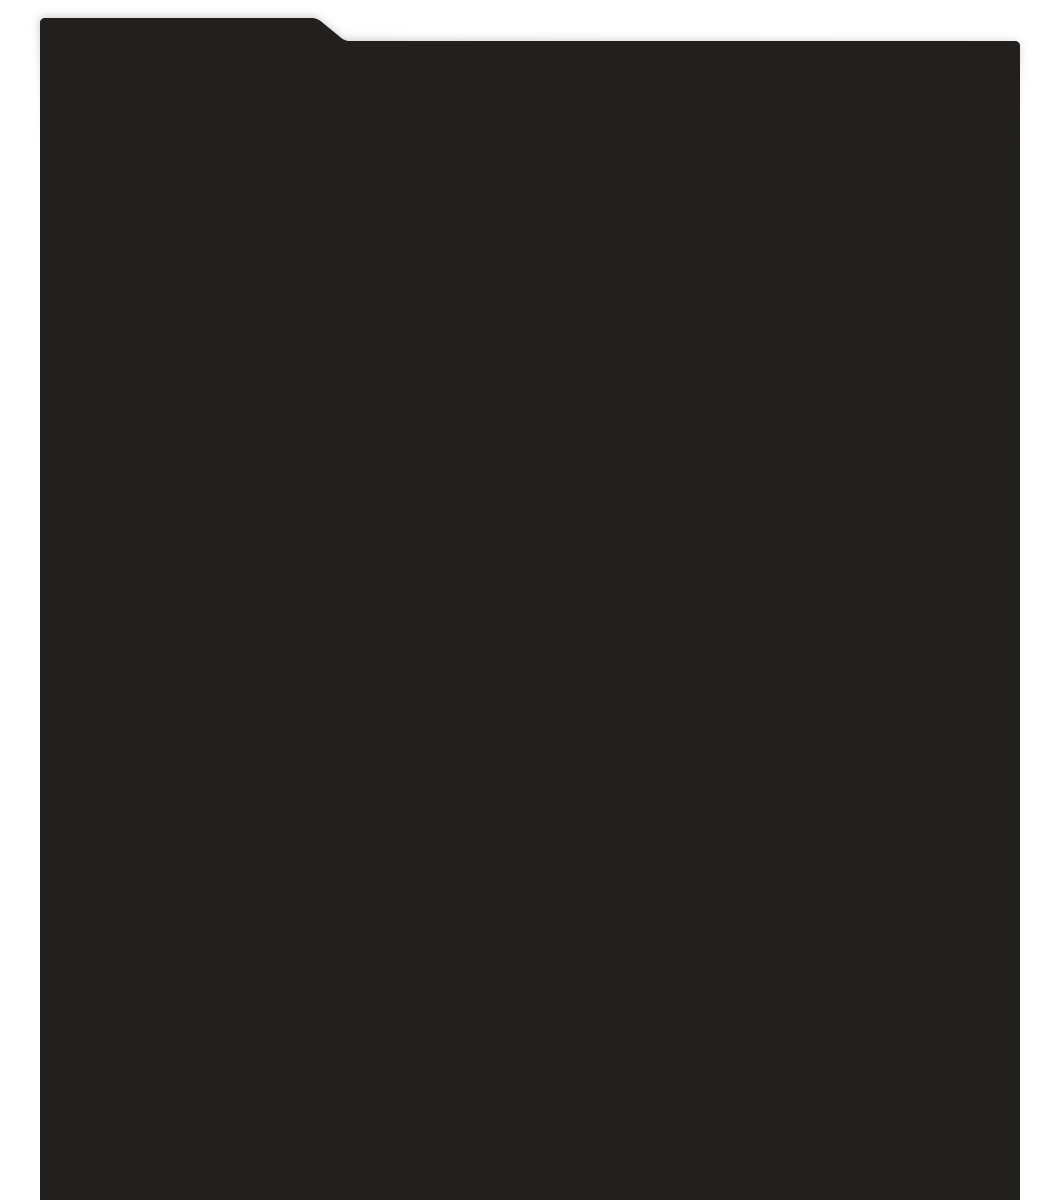
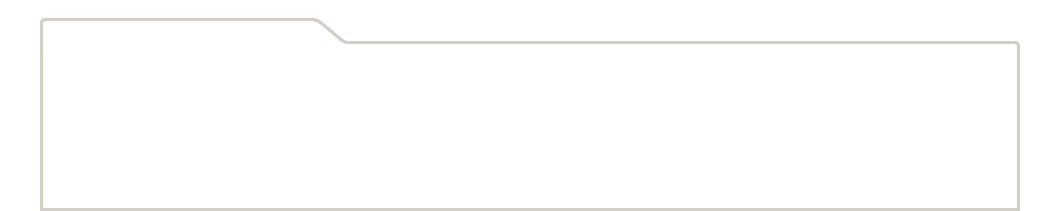
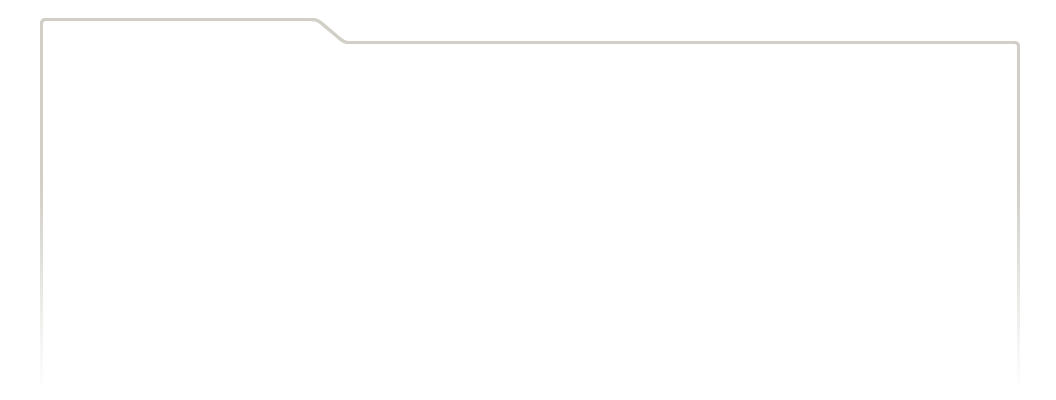
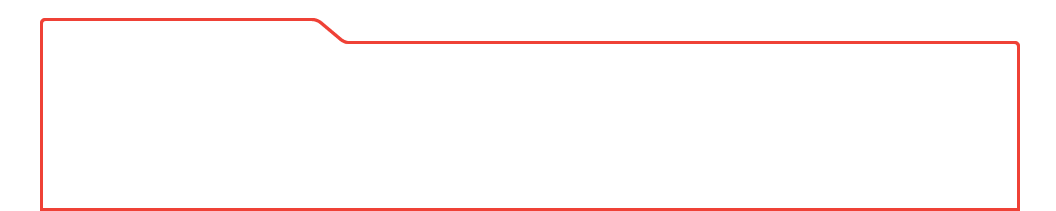
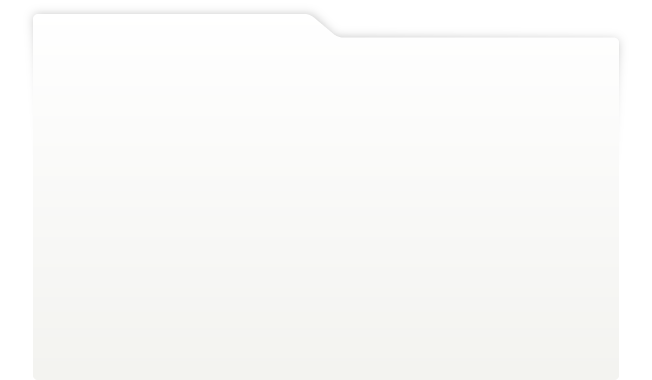
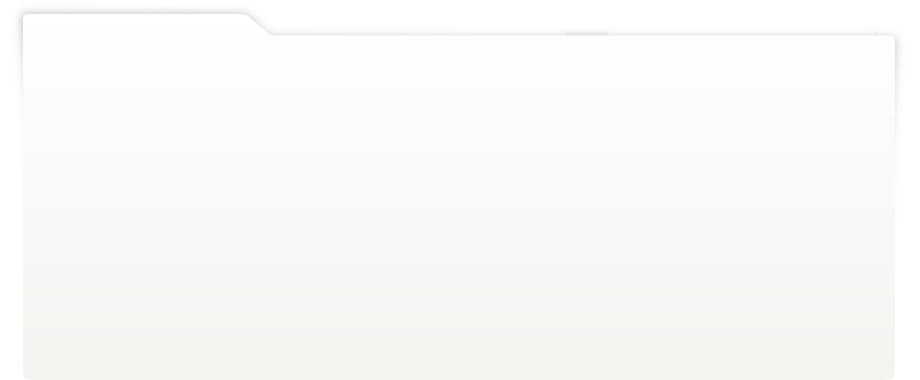
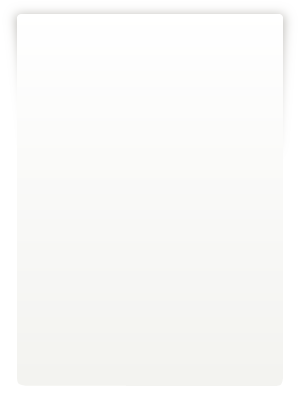
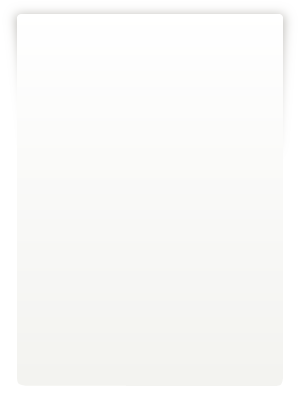
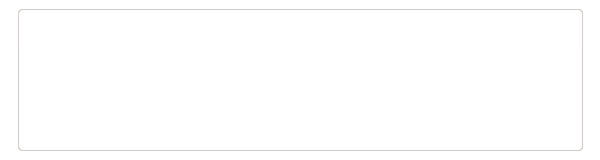
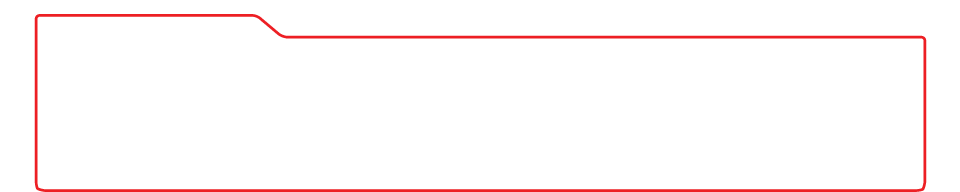
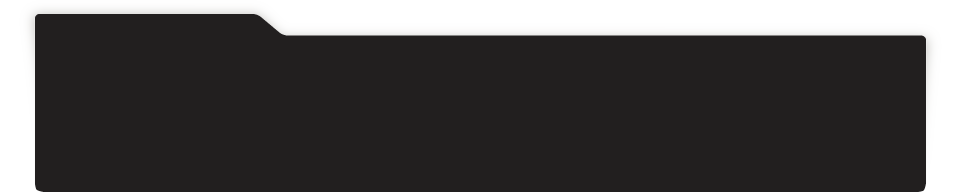
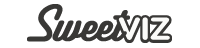
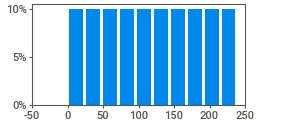
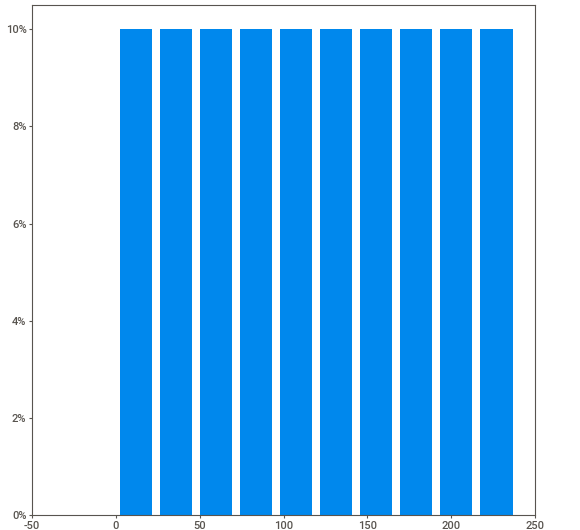
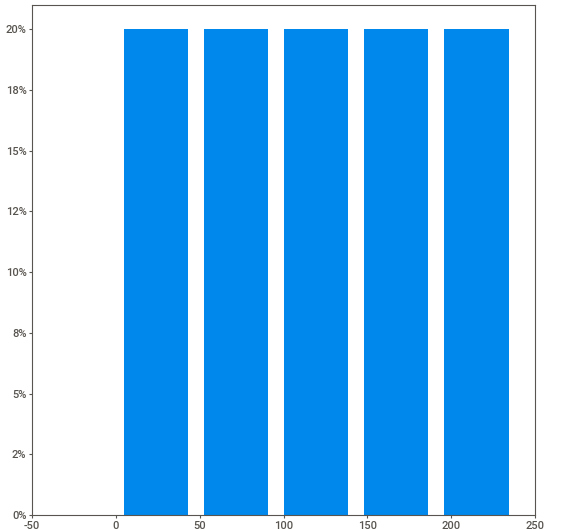
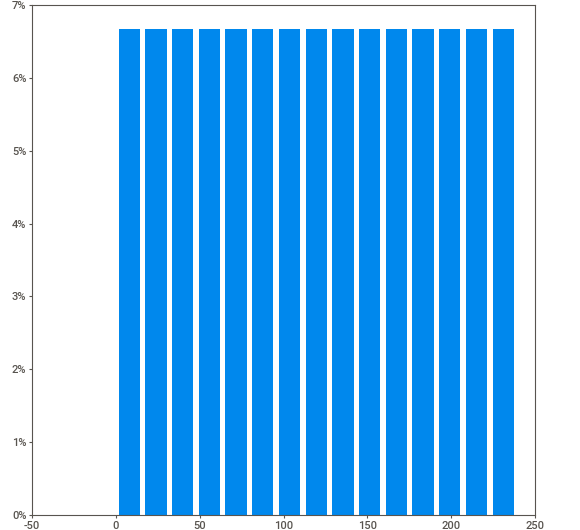
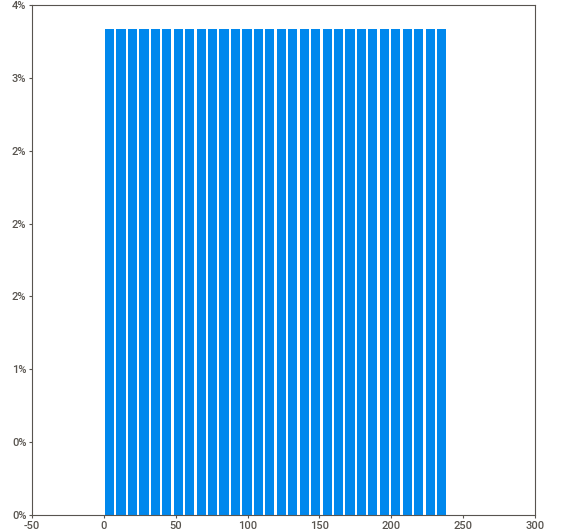
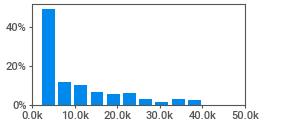
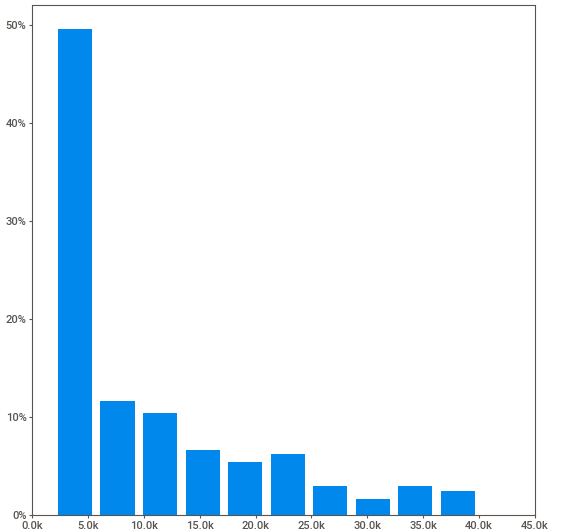
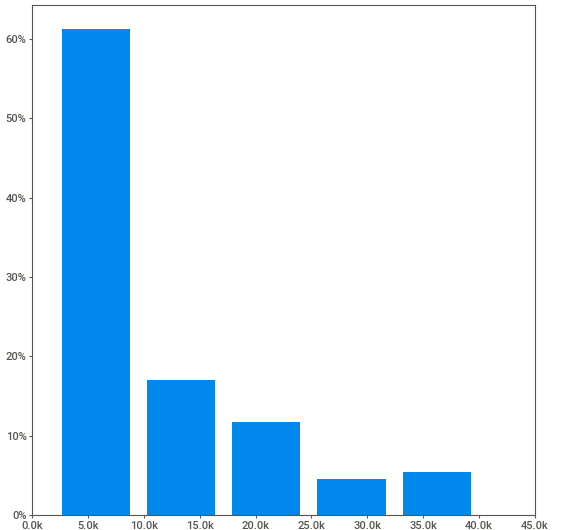
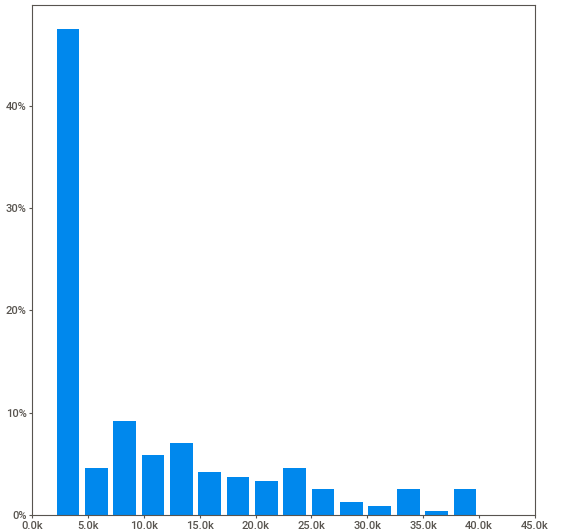
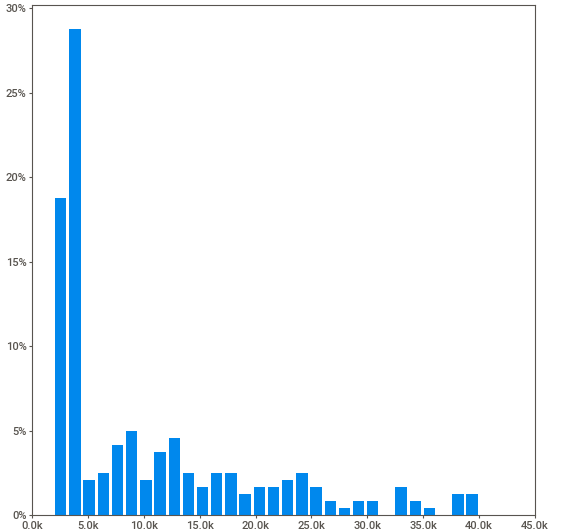
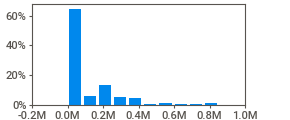
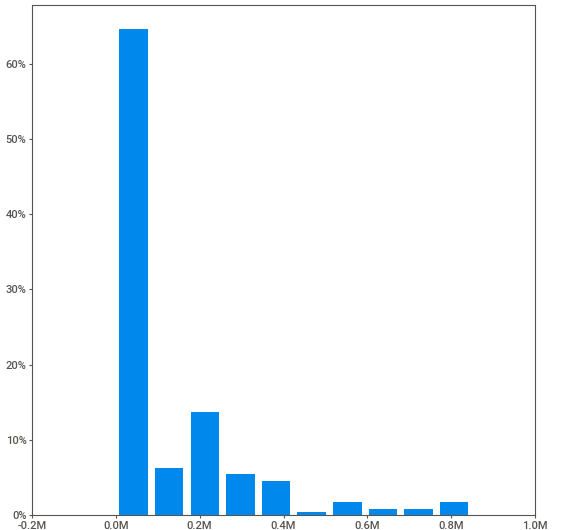
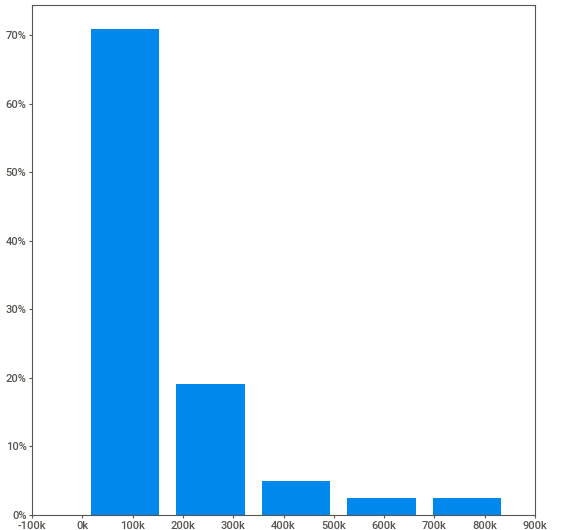
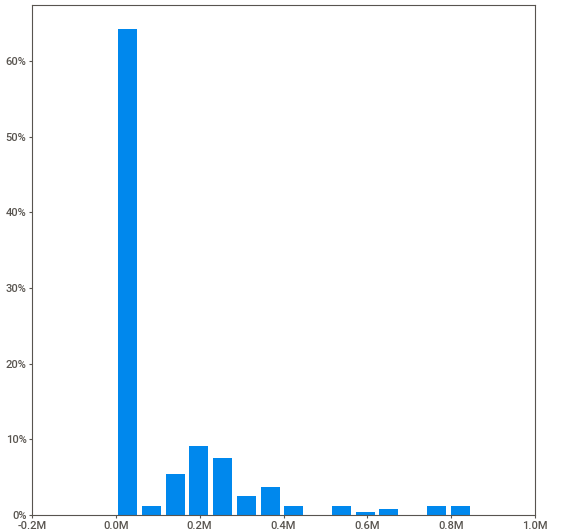
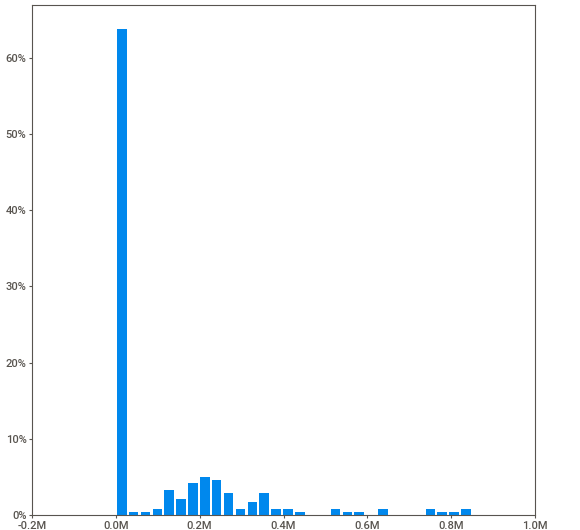
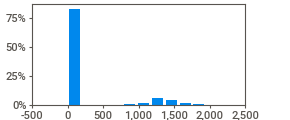
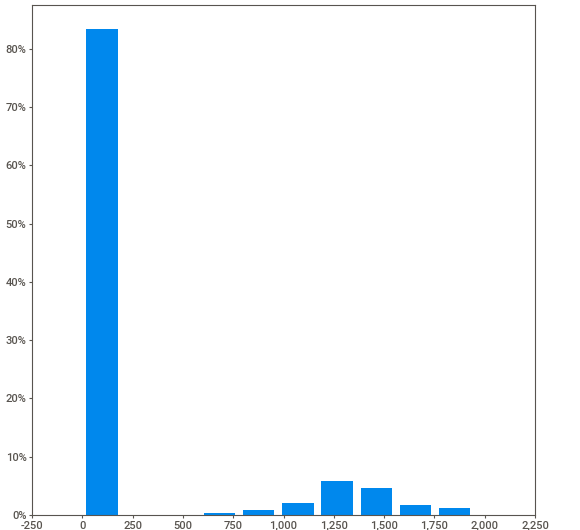
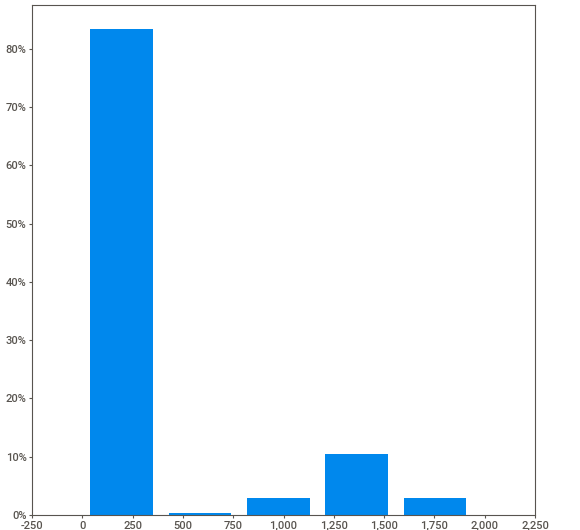
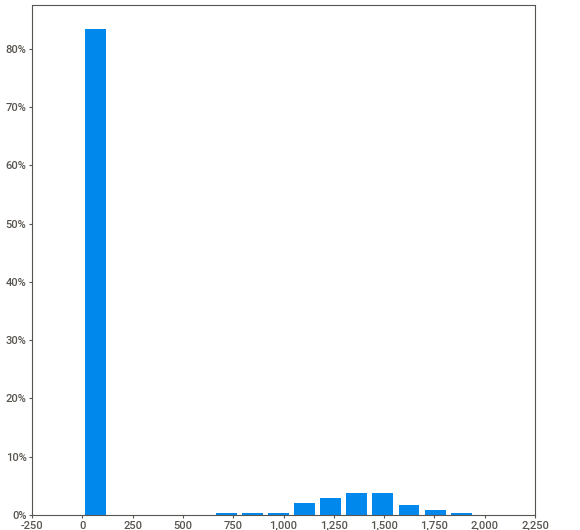
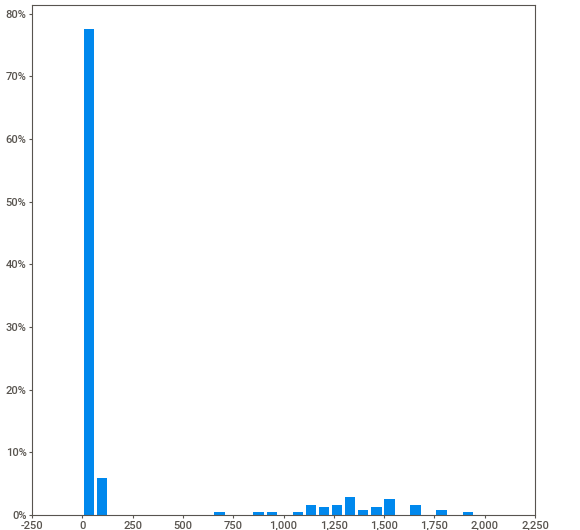
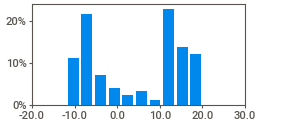
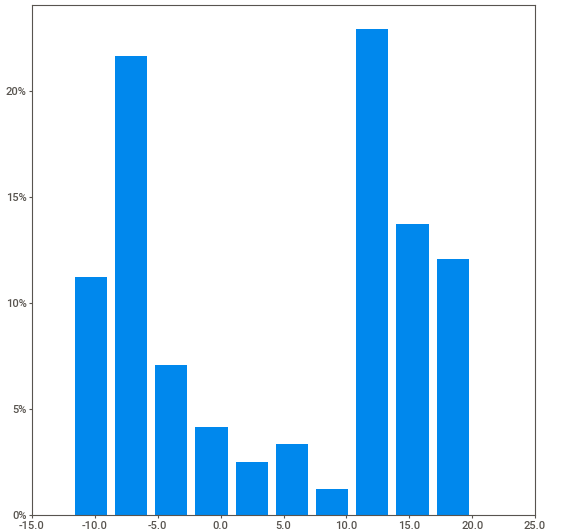
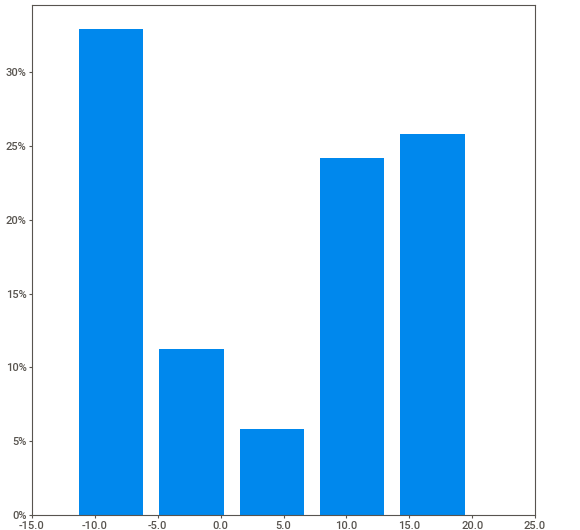
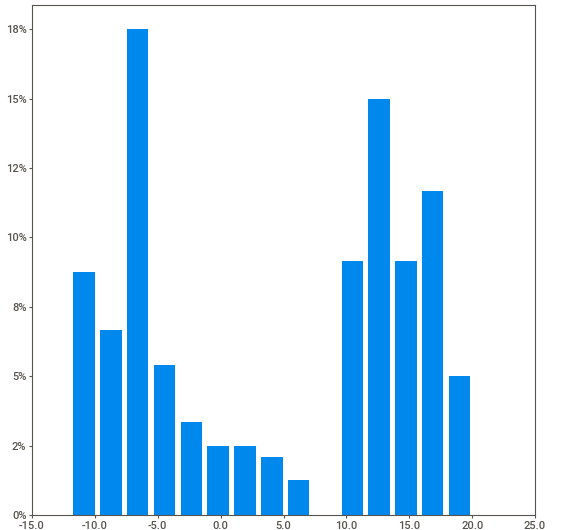
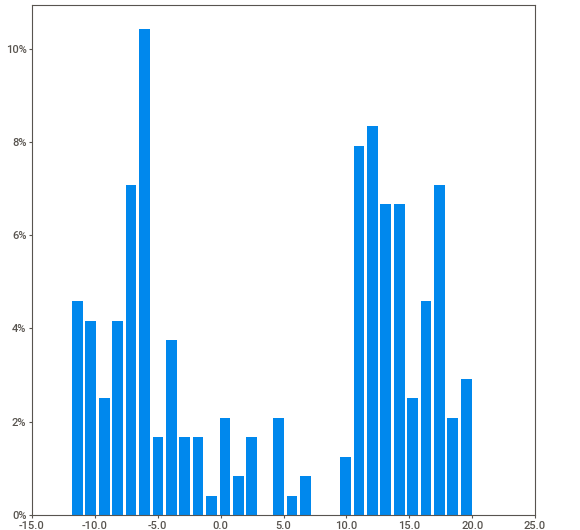
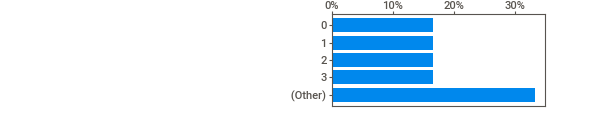
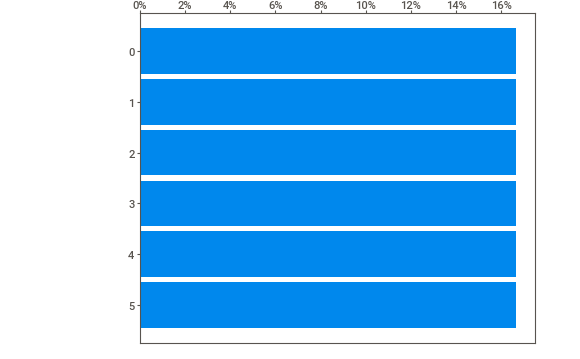
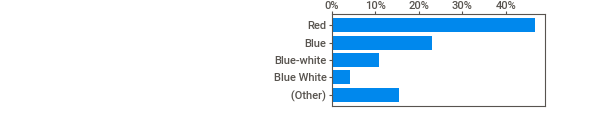
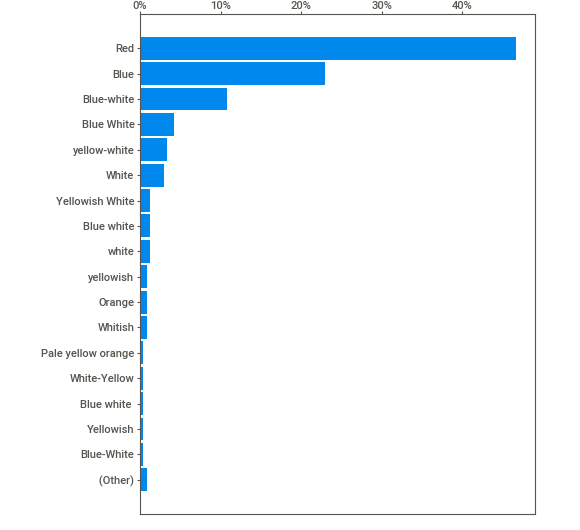
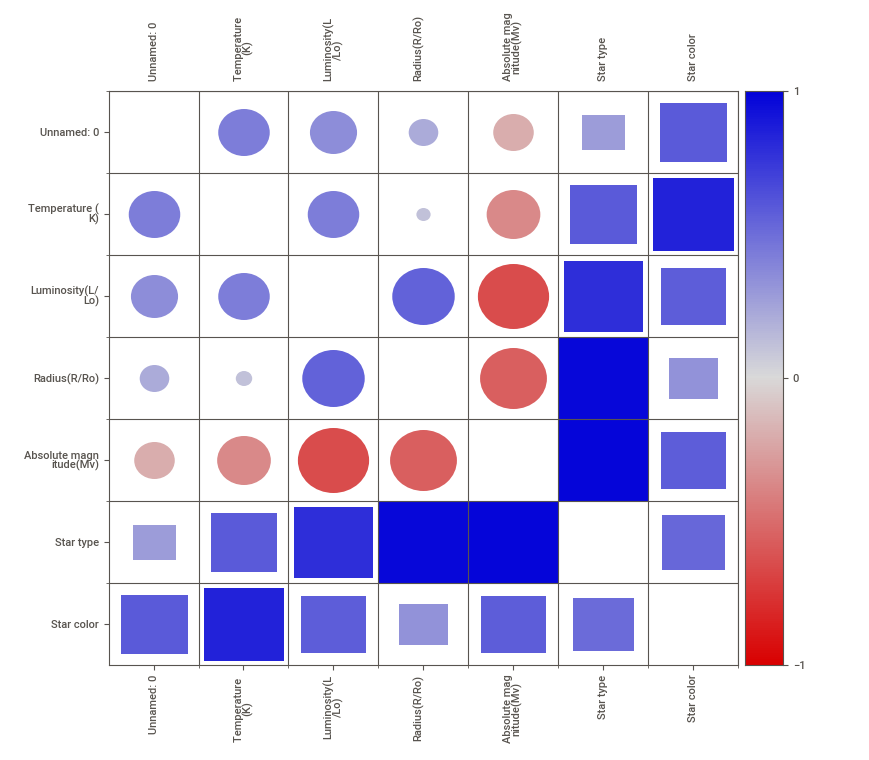
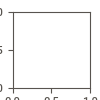

In [9]:
my_report = sv.analyze(data)
my_report.show_notebook(scale=0.8)

1. Названия столбцов необходимо переименовать в соответсвии с рекомендациями PIP8.
2. Признак `Unnamed: 0` - вероятно, индекс изученной звезды в обсерватории. Данный признак не несет в себе информацию для обучения нейронной сети и будет удален. 
3. Признак `Temperature (K)` имеет высокую корреляцию с цветом звезды: 0.84. Максимальное значение достигает при 40 000, минимальное: 1939, медиана: 5776, среднее: 10497.
4. Признак `Luminosity(L/Lo)` имеет высокую корреляцию с типом звезды: 0.79; и признаком `Absolute magnitude(Mv)`: -0.69. Максимальное значение достигает при 849 420, минимальное: 0.00008, медиана: 0.0705, среднее: 107 188.
5. Признак `Radius(R/Ro)` имеет высокую корреляцию с типом звезды: 0.98; и признаком `Absolute magnitude(Mv)`: -0.61. Максимальное значение достигает при 1948.5, минимальное: 0.0084, медиана: 0.76, среднее: 237.
6. Признак `Star type` имеет высокую корреляцию с `Absolute magnitude(Mv)`: 0.98; `Radius(R/Ro)`: 0.98, и признаком `Luminosity(L/Lo)`: 0.79. Все 6 типов звезд распределены равномерно, для каждой категории ровно 40 значений. Тип данных int, изменю на category. 
7. Признак `Star color` имеет высокую корреляцию с `Absolute magnitude(Mv)`: 0.84. Всего 19 уникальных значений. В данном признаке есть неявные дубликаты среди названий цветов, необходимо их устранить.  
8. Признаки распределены не нормально, пропуски отсутствуют, явные дубликаты отсутствуют. 

In [10]:
#перед началом редактирования данных сделаю копию датасета
df = data.copy()

In [11]:
# переименование столбцов
df.columns = [re.sub('(?<!^)(?=[A-Z])', '_', col).lower() for col in df.columns]
rename_dict = {'unnamed: 0':'unnamed',
               'temperature (_k)':'temperature',
               'luminosity(_l/_lo)':'luminosity',
               'radius(_r/_ro)':'radius',
               'absolute magnitude(_mv)':'absolute_magnitude',
               'star type':'star_type',
               'star color':'star_color'}

df.rename(columns = rename_dict, inplace = True)


print(df.columns)

Index(['unnamed', 'temperature', 'luminosity', 'radius', 'absolute_magnitude',
       'star_type', 'star_color'],
      dtype='object')


In [12]:
# удаление столбца unnamed
df = df.drop(['unnamed'], axis=1)

In [13]:
df['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [14]:
#преобразование букв в нижний регистр
df['star_color'] = df['star_color'].str.lower()
#удаление пробелов в начале и в конце строки
df['star_color'] = df['star_color'].str.replace('\s+', ' ').str.strip()
#замена пробелов на тире
df['star_color'] = df['star_color'].str.replace(' ', '-')
#замена yellow-white на white-yellow
df['star_color'] = df['star_color'].str.replace('yellow-white', 'white-yellow')
sorted(df['star_color'].unique())

['blue',
 'blue-white',
 'orange',
 'orange-red',
 'pale-yellow-orange',
 'red',
 'white',
 'white-yellow',
 'whitish',
 'yellowish',
 'yellowish-white']

In [15]:
#проверка на наличие дубликатов после внесенных изменений 
df.duplicated().sum()

0

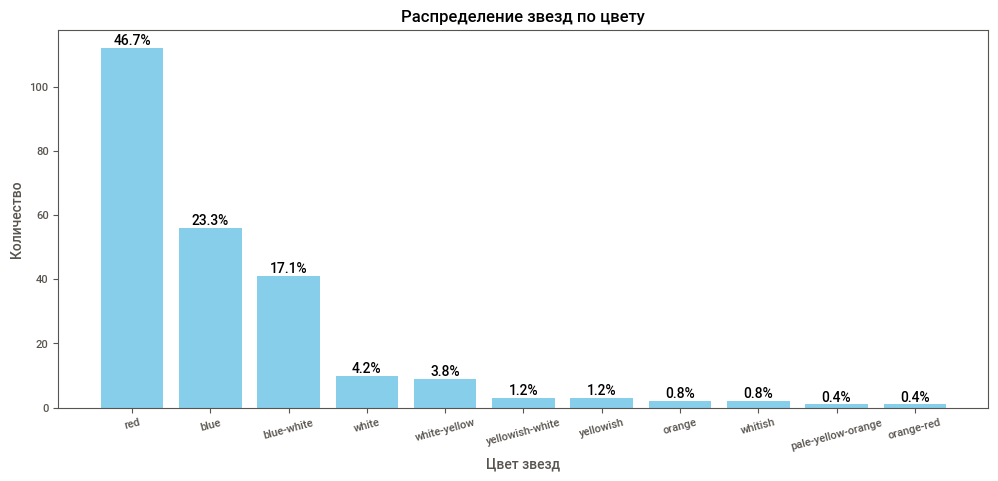

In [16]:
plot_column_distribution(df, 'star_color', 'Цвет звезд', 'Распределение звезд по цвету')

Самые распространенные звезды по цвету - это red (46,7%), blue (23.3%), blue-white (17.1%), white (4.2%) и white-yellow (3.8%).
Меньше всего распространены звезды: yellowish и yellowish-white (1.2%), orange и whitich (0.8%), orange-red и pale-yellow-orange (0.4%) - объединю их в общую категорию other.

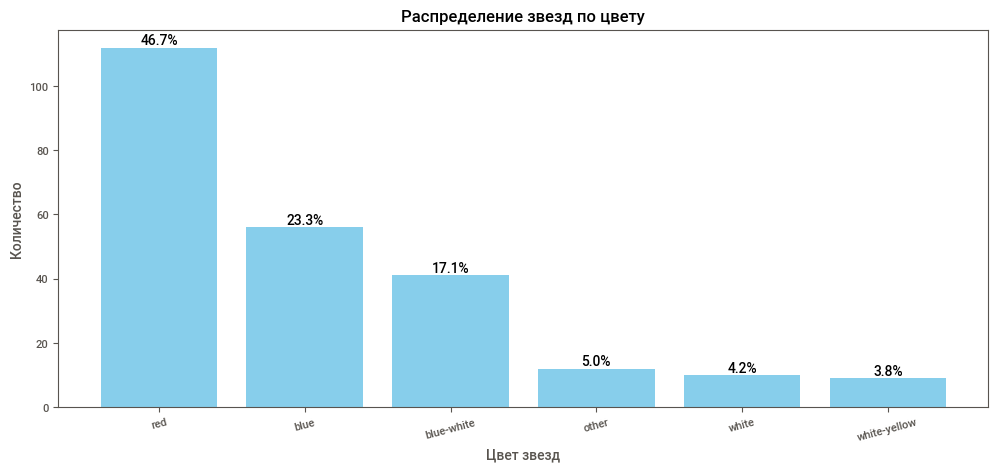

In [17]:
#замена малочисленных категорий на other 
small_categories = ['yellowish', 'yellowish-white', 'orange', 'whitish', 'orange-red', 'pale-yellow-orange']
df['star_color'] = df['star_color'].apply(lambda x: 'other' if x in small_categories else x)
sorted(df['star_color'].unique())

plot_column_distribution(df, 'star_color', 'Цвет звезд', 'Распределение звезд по цвету')

Сейчас всего шесть категорий звезд по цвету, из них other занимает 5%

In [18]:
#таблица медианных значений численных параметром по каждому типу звезд
median_values = pd.DataFrame(df.groupby('star_type').agg(['median'])).round(3)

print(median_values.to_string())

          temperature  luminosity    radius absolute_magnitude
               median      median    median             median
star_type                                                     
0              2935.0       0.001     0.106             17.145
1              3314.0       0.003     0.338             12.605
2             13380.0       0.001     0.010             12.340
3             12560.5     738.500     5.712             -1.180
4             12821.0  242145.000    43.500             -6.235
5              3766.0  266500.000  1352.500             -9.915


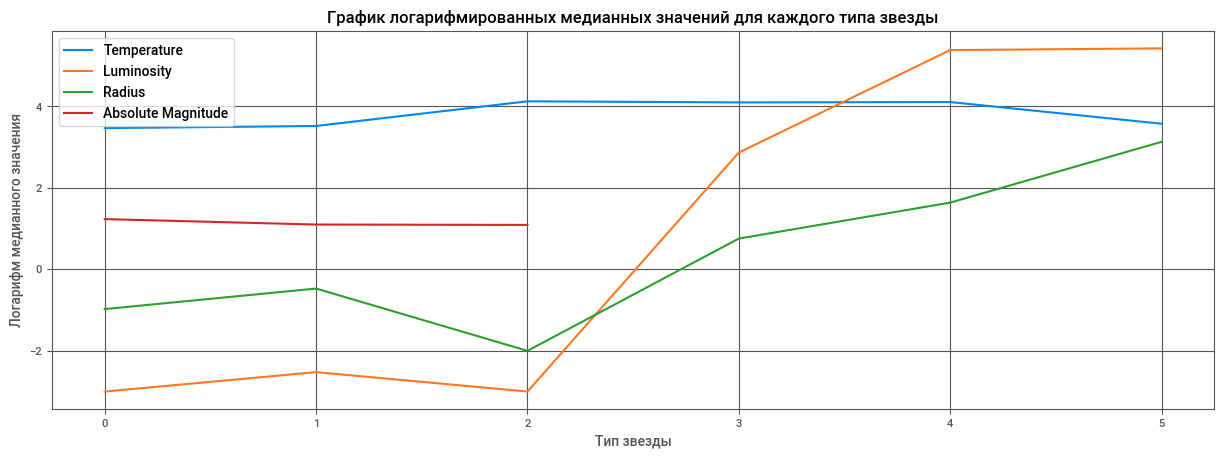

In [19]:
star_types = [0, 1, 2, 3, 4, 5]

# Логарифмирование значений медиан
temperature_median_log = np.log10(median_values['temperature'])
luminosity_median_log = np.log10(median_values['luminosity'])
radius_median_log = np.log10(median_values['radius'])
absolute_magnitude_median_log = np.log10(median_values['absolute_magnitude'])

plt.figure(figsize=(15, 5))
plt.plot(star_types, temperature_median_log, label='Temperature')
plt.plot(star_types, luminosity_median_log, label='Luminosity')
plt.plot(star_types, radius_median_log, label='Radius')
plt.plot(star_types, absolute_magnitude_median_log, label='Absolute Magnitude')

plt.xlabel('Тип звезды')
plt.ylabel('Логарифм медианного значения')
plt.title('График логарифмированных медианных значений для каждого типа звезды')
plt.legend()
plt.grid(True)

plt.show()

- Звезды 2, 3 и 4 типов обладают максимально высокой медианной температурой.
- Медианная светимость сильно увеличивается по нарастающей для звезд 3, 4 и 5 типов.
- Наименьший медианный радиус характерен для звезд второго типа, затем постепенно увеличивается для звезд 3, 4 и 5 типов.
- Абсолютная звездная величина также значительно ниже для звезд 3, 4 и 5 типов.

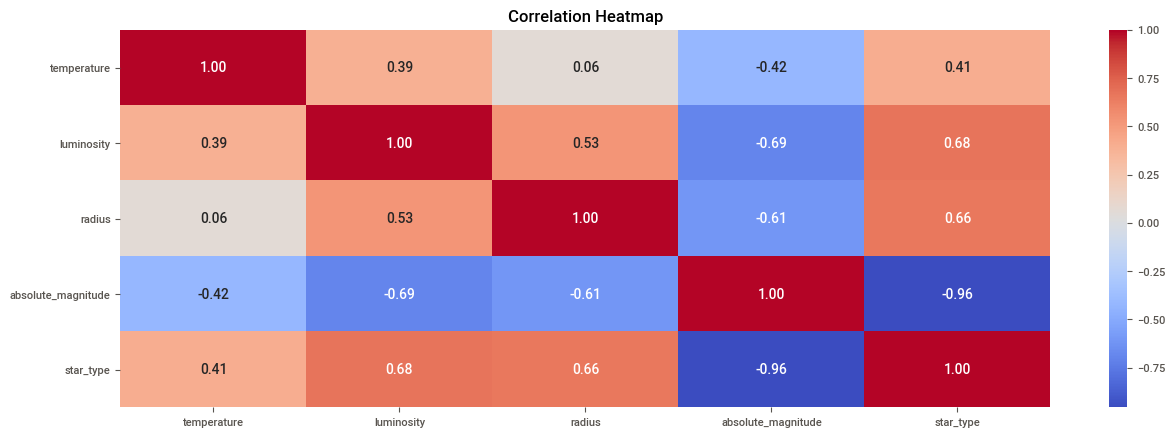

In [20]:
# Создание корреляционной матрицы
correlation_matrix = df.corr()

# Создание тепловой карты
plt.figure(figsize=(15, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Корреляционная матрица Пирсона для численных признаков показывает следующее:
- Абсолютная звездная величина демонстрирует достаточно высокую отрицательную корреляцию с такими признаками, как светимость (-0.69), радиус (-0.61) и температура (-0.42).
- Радиус и светимость взаимосвязаны с коэффициентом корреляции 0.53, в то время как минимальная корреляция наблюдается между радиусом и температурой: 0.06.

### Подготовка обучающей и тестовой выборки

1. Разделение на обучающую и тестовую выборки
2. Трансформирование данных: 
   - Обработка числовых признаков с помощью StandardScaler() для масштабирования числовых признаков.
   - OneHotEncoder() для кодирования категориальных признаков.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         240 non-null    int64  
 1   luminosity          240 non-null    float64
 2   radius              240 non-null    float64
 3   absolute_magnitude  240 non-null    float64
 4   star_type           240 non-null    int64  
 5   star_color          240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


In [22]:
# изменение типа данных 
df['star_color'] = df['star_color'].astype('category')
df['star_type'] = df['star_type'].astype('category')

In [23]:
X = df[['luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']]
y = df['temperature']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Определение списка столбцов категориальных и числовых данных
cat_cols = X_train.select_dtypes(include=['category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

print('cat_columns:', cat_cols)
print('num_columns:', num_cols)

num_pipeline = make_pipeline(StandardScaler())

column_transformer = make_column_transformer(
    (num_pipeline, num_cols),
    (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    remainder='passthrough'
)

(192, 5) (48, 5) (192,) (48,)
cat_columns: ['star_type', 'star_color']
num_columns: ['luminosity', 'radius', 'absolute_magnitude']


In [24]:
#трансформация данных
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)
print('нулевой элемент x_train:', X_train[0])

нулевой элемент x_train: [-0.5812899  -0.43358008  0.9226767   1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.        ]


In [25]:
print("Тип данных в X_train:", type(X_train))
print("Тип данных в X_test:", type(X_test))
print("Тип данных в y_train:", type(y_train))
print("Тип данных в y_test:", type(y_test))

Тип данных в X_train: <class 'numpy.ndarray'>
Тип данных в X_test: <class 'numpy.ndarray'>
Тип данных в y_train: <class 'pandas.core.series.Series'>
Тип данных в y_test: <class 'pandas.core.series.Series'>


In [26]:
# Преобразование в тензор
X_train =  torch.FloatTensor(X_train)
X_test =  torch.FloatTensor(X_test)
y_train =  torch.FloatTensor(y_train.values)
y_test =  torch.FloatTensor(y_test.values)

### Вывод

**Результаты предобработки данных:**
1. Названия столбцов переименованы в соответствии с рекомендациями PEP8.
2. Признак "Unnamed: 0" удален. Вероятно, это индекс изученной звезды в обсерватории. Данный признак не несет в себе информации для обучения нейронной сети.
3. Изменен тип данных на "category" для столбцов "star_color" и "star_type".
4. В признаке "star_color" исправлены неявные дубликаты, малочисленные категории объеденены в other.

**Проанализировано:**
1. Признаки распределены не нормально, пропуски отсутствуют, явные дубликаты отсутствуют.
2. Все 6 типов звезд распределены равномерно, для каждой категории ровно 40 значений.
3. Самые распространенные звезды по цвету - это red (46,7%), blue (23.3%), blue-white (17.1%), white (4.2%) и white-yellow (3.8%).
    Меньше всего распространены звезды: yellowish и yellowish-white (1.2%), orange и whitich (0.8%), orange-red и pale-yellow-orange (0.4%) - все объеденены в общую категорию other. После преобразования категория other занимает 5% данных.
4.  Корреляция численных признаков:               
    - Звезды 2, 3 и 4 типов обладают максимально высокой медианной температурой.
    - Медианная светимость сильно увеличивается по нарастающей для звезд 3, 4 и 5 типов.
    - Наименьший медианный радиус характерен для звезд второго типа, затем постепенно увеличивается для звезд 3, 4 и 5 типов.
    - Абсолютная звездная величина также значительно ниже для звезд 3, 4 и 5 типов.
5. Корреляция с категориальными признаками: 
    - Признак `Star type` имеет высокую корреляцию с `Absolute magnitude(Mv)`: 0.98; `Radius(R/Ro)`: 0.98, и признаком `Luminosity(L/Lo)`: 0.79.
    - Признак `Star color` имеет высокую корреляцию с `Absolute magnitude(Mv)`: 0.84. 
    
    
**При построении нейронной сети необходима L2-Регуляризация весов для устранения влияния высокой корреляции между категориальными и численными значениями.** 
    
**Подготовка обучающей и тестовой выборки:**

1. Разделение на обучающую и тестовую выборки
2. Трансформирование данных: масштабирование числовых признаков с помощью StandartScaler(), кодирование категориальных признаков с помощью  OneHotEncoder().

## Построение базовой нейронной сети

1. Определение количества нейронов на каждом слое: 
   - `in_neurons` - количество нейронов на входном слое, равное количеству признаков во входных данных `X_train`.
   - `hidden_neurons_1` - количество нейронов на первом скрытом слое.
   - `hidden_neurons_2` - количество нейронов на втором скрытом слое.
   - `out_neurons` - количество нейронов на выходном слое (1 нейрон).

2. Создание класса нейронной сети `Base_NN(nn.Module)`:
   - Инициализация метода `init` с параметрами `in_neurons`, `hidden_neurons_1`, `hidden_neurons_2`, `out_neurons`.
   - В методе `init` создаются слои нейронной сети.
   
   На скрытых и выходных слоях используются функции активации nn.LeakyReLU() и nn.ReLU(). nn.LeakyReLU() умножает отрицательные значения на небольшой коэффициент (обычно около 0.01), что позволяет избежать проблемы затухания градиента во время обучения нейронных сетей, nn.ReLU() заменяет все отрицательные значения нулем

3. Метод `forward(self, x)` определяет последовательность прямого прохода через нейронную сеть.

4. Инициализация нейронной сети `net` с передачей параметров количества нейронов на каждом слое.

Base_NN создает нейронную сеть с тремя скрытыми слоями, используя функции активации LeakyReLU после первого и второго скрытых слоое и ReLU на выходном, и полносвязные слои для обучения на данных `X_train`.

In [29]:
in_neurons = X_train.shape[1]
hidden_neurons_1 = 8
hidden_neurons_2 = 5
out_neurons = 1

# класс для задания архитектуры нейронной сети
class Base_NN(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(Base_NN, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x


# Инициализация нейросети
net = Base_NN(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)

In [30]:
# Функция для инициализации весов
'''
функция используется для инициализации весов нейронной сети
с помощью метода Kaiming (He) для слоев типа `nn.Linear`.

Особенности метода Kaiming (He):
- Этот метод инициализации весов оптимизирован для функции активации ReLU.
- Kоэффициенты инициализации весов рассчитываются исходя из количества входных нейронов
и специфичных параметров функции активации, чтобы обеспечитьстабильное распространение
градиентов во время обучения.
'''

def initializing_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(
            layer.weight,
            mode='fan_in',
            nonlinearity='relu'
        )

# Инициализация весов нейросети
net.apply(initializing_weights)

Base_NN(
  (fc1): Linear(in_features=13, out_features=8, bias=True)
  (ac1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=8, out_features=5, bias=True)
  (ac2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (ac3): ReLU()
)

In [31]:
#обучение модели
def train(X_train, y_train):
    '''
    обучение модели с применением L2-регуляризации весов
    '''
    net.train()
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    
    # L2-регуляризация весов

    l2_lambda = 0.005
    l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
    loss_value = torch.sqrt(loss(preds, y_train))+ l2_lambda * l2_norm
    loss_value.backward()

    optimizer.step()

In [32]:
#предсказания на тестовой выборки 
def test(epoch):
    net.eval()
    test_preds = net.forward(X_test).flatten()
    print('Epoch #:', epoch)
    print('RMSE =', torch.sqrt(loss(test_preds, y_test)).item())
    return test_preds

In [33]:
# Создание оптимизатора и функции потерь
'''
Adam - это метод оптимизации, который сочетает в себе преимущества адаптивного
градиентного спуска и адаптивного градиентного спуска с квадратом градиента. 
'''
torch.manual_seed(42)
optimizer = torch.optim.Adam(net.parameters(), lr=1.6e-3)
loss = nn.MSELoss()

# Обучение нейросети
num_epochs = 10001

for epoch in range(num_epochs):
    train(X_train, y_train)
    if epoch % 1000 == 0:
        base_preds = test(epoch)

Epoch #: 0
RMSE = 15253.0205078125
Epoch #: 1000
RMSE = 14290.427734375
Epoch #: 2000
RMSE = 10544.9130859375
Epoch #: 3000
RMSE = 8319.970703125
Epoch #: 4000
RMSE = 7744.232421875
Epoch #: 5000
RMSE = 7023.43359375
Epoch #: 6000
RMSE = 6354.0361328125
Epoch #: 7000
RMSE = 5628.9736328125
Epoch #: 8000
RMSE = 5068.77978515625
Epoch #: 9000
RMSE = 4798.93115234375
Epoch #: 10000
RMSE = 4658.4130859375


**На 10000 эпохе вышло RMSE = 4715.**

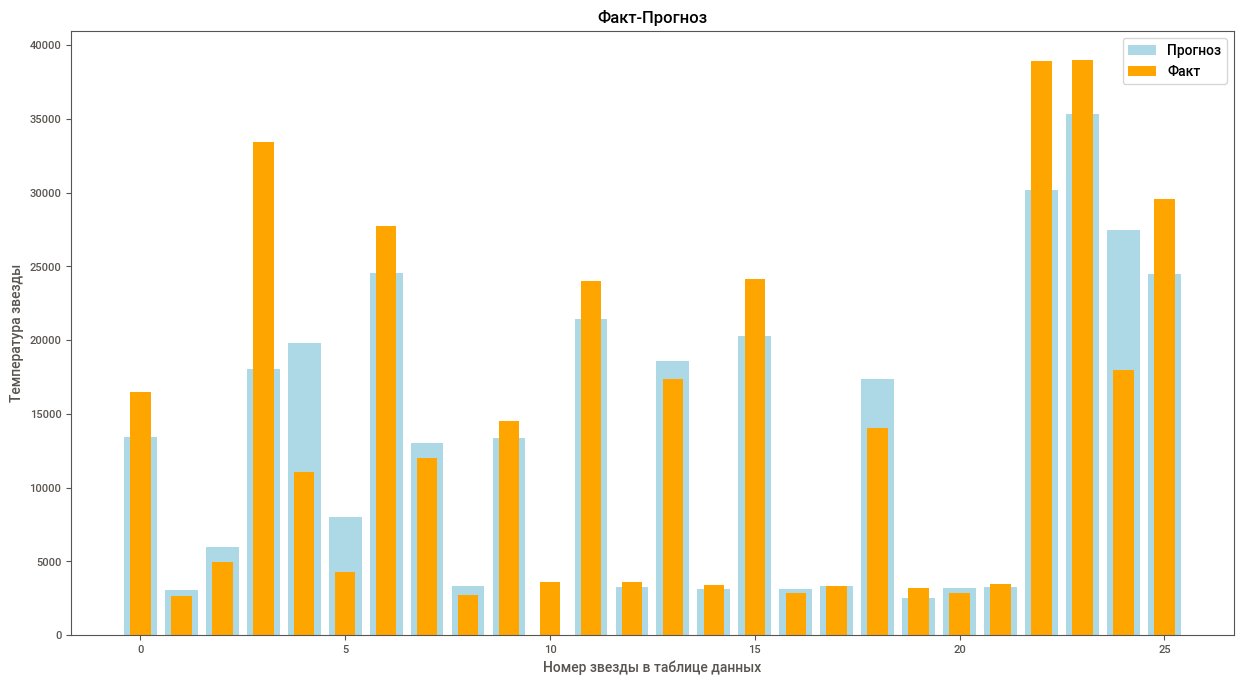

In [34]:
#график "Факт-Прогноз" по результатам нейросети
predictions_graph(base_preds)

Модель хорошо выдает предсказания для звезд с низкой температурой, куда хуже результат для звезд с более высокой температурой.

### Вывод по созданию базовой модели

Создана трехслойная нейронная сеть с тремя скрытыми слоями, с использованием функции активации LeakyReLU после первого и второго скрытых слоое и ReLU на выходном, и полносвязные слои для обучения на данных `X_train`:
- количество нейронов на первом скрытом слое 8, на втором 5, на выходном 1. 
- при обучении модели использовалась L2-регуляризация с коэффициентом l2_lambda = 0.005
- использовался оптимизатор Adam с параметром lr=1.6e-3
- количество эпох 10 000

**На 10000 эпохе вышло RMSE = 4715.**

По результату графика Фактор-Прогноз модель хорошо выдает предсказания для звезд с низкой температурой, куда хуже результат для звезд с более высокой температурой.

## Улучшение нейронной сети

### Перебор оптимизатора

Перебор будет происходить с:
- предыдущим оптимизатором Adam
- NAdam (Nesterov Adam) вариант оптимизатора Adam с добавлением метода Нестерова для улучшения сходимости. 
- Adamax вариант оптимизатора Adam, который использует бесконечную норму вместо второго момента градиента для обновления весов.

Для каждого оптимизатора будут подобраны различные значения Learning Rate и Weight Decay.

In [35]:
#torch.manual_seed(42)

class Improved_NN(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(Improved_NN, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x

in_neurons = X_train.shape[1]
hidden_neurons_1 = 8
hidden_neurons_2 = 5
out_neurons = 1

net = Improved_NN(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
net.apply(initializing_weights)

optimizers = [torch.optim.Adam(net.parameters(), lr=1.6e-3),
              torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-2),
              torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-3),
              torch.optim.NAdam(net.parameters(), lr=1e-2, weight_decay=1e-2),
              torch.optim.NAdam(net.parameters(), lr=1e-3, weight_decay=1e-3),
              torch.optim.Adamax(net.parameters(), lr=1e-2, weight_decay=1e-2),
              torch.optim.Adamax(net.parameters(), lr=1e-3, weight_decay=1e-3)
             ]

loss = nn.MSELoss()

num_epochs = 10001

for optimizer in optimizers:
    net.apply(initializing_weights)
    print(f"Training with optimizer: {optimizer}")
    for epoch in range(num_epochs):
        train(X_train, y_train)
        if epoch % 1000 == 0:
            improved_preds = test(epoch)

Training with optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0016
    weight_decay: 0
)
Epoch #: 0
RMSE = 15252.849609375
Epoch #: 1000
RMSE = 14158.83203125
Epoch #: 2000
RMSE = 9900.21875
Epoch #: 3000
RMSE = 8005.1259765625
Epoch #: 4000
RMSE = 7594.669921875
Epoch #: 5000
RMSE = 6691.28369140625
Epoch #: 6000
RMSE = 5946.35595703125
Epoch #: 7000
RMSE = 5263.22802734375
Epoch #: 8000
RMSE = 4842.49560546875
Epoch #: 9000
RMSE = 4755.74169921875
Epoch #: 10000
RMSE = 4815.32373046875
Training with optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0.01
)
Epoch #: 0
RMSE = 15253.0625
Epoch #: 1000
RMSE = 5042.205078125
Epoch #: 2000
RMSE = 4782.373046875
Epoch #: 3000
RMSE = 4672.9794921875
Epoch #: 4000
RMSE = 4670.5859375
Epoch #: 5000
RMSE = 4798.10986328125
Epoch #: 6000
RMSE = 4744.92822265625
Epoch #: 7000
RMSE = 4769.5087890625
Epoch #: 8000
RMSE =

Лучший оптимизатор NAdam c параметрами: lr=1e-2, weight_decay=1e-2, минимальное RMSE вышло 4332, на 2000 эпохе

### Перебор размера батчей

In [36]:
data_train = torch.utils.data.TensorDataset(X_train, y_train)
data_test = torch.utils.data.TensorDataset(X_test, y_test)

In [37]:
in_neurons = X_train.shape[1]
hidden_neurons_1 = 8
hidden_neurons_2 = 5
out_neurons = 1

# класс для задания архитектуры нейронной сети
class Improved_NN_batch(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(Improved_NN_batch, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x

    
in_neurons = X_train.shape[1]
hidden_neurons_1 = 8
hidden_neurons_2 = 5
out_neurons = 1

net = Improved_NN_batch(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
net.apply(initializing_weights)

optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2, weight_decay=1e-2)
loss = nn.MSELoss()

num_epochs = 10001
batch_sizes = [16, 32, 64, 80]


for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle = True)
    net.apply(initializing_weights)
    for epoch in range(num_epochs):
        for batch in train_loader:
            X, y = batch
            train(X, y)
        if epoch % 1000 == 0:
            improved_preds_batch = test(epoch)

Training with batch size: 16
Epoch #: 0
RMSE = 15251.9228515625
Epoch #: 1000
RMSE = 4708.2138671875
Epoch #: 2000
RMSE = 4704.75
Epoch #: 3000
RMSE = 4663.34619140625
Epoch #: 4000
RMSE = 4529.52294921875
Epoch #: 5000
RMSE = 4508.46826171875
Epoch #: 6000
RMSE = 4472.17041015625
Epoch #: 7000
RMSE = 4472.90576171875
Epoch #: 8000
RMSE = 4500.75830078125
Epoch #: 9000
RMSE = 4406.13525390625
Epoch #: 10000
RMSE = 4427.4306640625
Training with batch size: 32
Epoch #: 0
RMSE = 15241.6484375
Epoch #: 1000
RMSE = 4989.57958984375
Epoch #: 2000
RMSE = 4996.8662109375
Epoch #: 3000
RMSE = 4990.44384765625
Epoch #: 4000
RMSE = 4908.13671875
Epoch #: 5000
RMSE = 4542.376953125
Epoch #: 6000
RMSE = 4566.720703125
Epoch #: 7000
RMSE = 4529.12451171875
Epoch #: 8000
RMSE = 4508.7978515625
Epoch #: 9000
RMSE = 4469.30908203125
Epoch #: 10000
RMSE = 4473.078125
Training with batch size: 64
Epoch #: 0
RMSE = 15240.587890625
Epoch #: 1000
RMSE = 5023.87255859375
Epoch #: 2000
RMSE = 4913.1767578125


Лучший размер батча 16, минимальное RMSE вышло 4472, на 6000 эпохе. Оптимизатор NAdam c параметрами: lr=1e-2, weight_decay=1e-2.

### Перебор dropout

#### dropout = 0.2

In [38]:
torch.manual_seed(42)

class Improved_NN_dropout1(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons, dropout):
        super(Improved_NN_dropout1, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x

    
in_neurons = X_train.shape[1]
hidden_neurons_1 = 8
hidden_neurons_2 = 5
out_neurons = 1

net = Improved_NN_dropout1(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons, dropout=0.2)
net.apply(initializing_weights)

optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2, weight_decay=1e-2)
loss = nn.MSELoss()

num_epochs = 10001

for epoch in range(num_epochs):
    train(X_train, y_train)
    if epoch % 1000 == 0:
        improved_preds_dropout1 = test(epoch)

Epoch #: 0
RMSE = 15252.8359375
Epoch #: 1000
RMSE = 5992.2568359375
Epoch #: 2000
RMSE = 5171.6328125
Epoch #: 3000
RMSE = 5053.25390625
Epoch #: 4000
RMSE = 5108.2890625
Epoch #: 5000
RMSE = 4985.3525390625
Epoch #: 6000
RMSE = 4931.91455078125
Epoch #: 7000
RMSE = 4880.89013671875
Epoch #: 8000
RMSE = 5037.25439453125
Epoch #: 9000
RMSE = 4908.28564453125
Epoch #: 10000
RMSE = 5000.03515625


**При параметре dropout=0.2, минимальное RMSE вышло 4880, на 7000 эпохе. Оптимизатор NAdam c параметрами: lr=1e-2, weight_decay=1e-2.**

#### dropout = 0.1

In [39]:
torch.manual_seed(42)

class Improved_NN_dropout2(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons, dropout):
        super(Improved_NN_dropout2, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x

    
in_neurons = X_train.shape[1]
hidden_neurons_1 = 8
hidden_neurons_2 = 5
out_neurons = 1

net = Improved_NN_dropout2(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons, dropout=0.1)
net.apply(initializing_weights)

optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2, weight_decay=1e-2)
loss = nn.MSELoss()

num_epochs = 10001

for epoch in range(num_epochs):
    train(X_train, y_train)
    if epoch % 1000 == 0:
        improved_preds_dropout2 = test(epoch)

Epoch #: 0
RMSE = 15252.8349609375
Epoch #: 1000
RMSE = 5395.28466796875
Epoch #: 2000
RMSE = 4761.23388671875
Epoch #: 3000
RMSE = 4765.107421875
Epoch #: 4000
RMSE = 4807.94921875
Epoch #: 5000
RMSE = 4800.78955078125
Epoch #: 6000
RMSE = 4792.77978515625
Epoch #: 7000
RMSE = 4749.197265625
Epoch #: 8000
RMSE = 4871.34130859375
Epoch #: 9000
RMSE = 4797.33154296875
Epoch #: 10000
RMSE = 4903.44189453125


**При параметре dropout=0.1, минимальное RMSE вышло 4761, на 2000 эпохе. Оптимизатор NAdam c параметрами: lr=1e-2, weight_decay=1e-2.**

In [40]:
'''

torch.manual_seed(42)

class Improved_NN2(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons, dropout):
        super(Improved_NN2, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x

    
in_neurons = X_train.shape[1]
hidden_neurons_1 = 8
hidden_neurons_2 = 5
out_neurons = 1

net = Improved_NN2(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons, dropout=0.2)
net.apply(initializing_weights)

optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2, weight_decay=1e-2)
loss = nn.MSELoss()

num_epochs = 10001
batch_sizes = [16, 32, 64, 80]
dropouts = [0.2, 0.3, 0.5, 0.6]


for batch_size in batch_sizes:
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle = True)
    for dropout in dropouts:
        print(f"Training with batch size: {batch_size} and dropout: {dropout}")
        net.apply(initializing_weights)
        for epoch in range(num_epochs):
            for batch in train_loader:
                X, y = batch
                train(X, y)
            if epoch % 1000 == 0:
                improved_preds = test(epoch)
'''

'\n\ntorch.manual_seed(42)\n\nclass Improved_NN2(nn.Module):\n    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons, dropout):\n        super(Improved_NN2, self).__init__()\n        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)\n        self.ac1 = nn.LeakyReLU()\n        self.dropout1 = nn.Dropout(dropout)\n        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)\n        self.ac2 = nn.LeakyReLU()\n        self.dropout2 = nn.Dropout(dropout)\n        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)\n        self.ac3 = nn.ReLU()\n\n    def forward(self, x):\n        x = self.fc1(x)\n        x = self.ac1(x)\n        x = self.dropout1(x)\n        x = self.fc2(x)\n        x = self.ac2(x)\n        x = self.dropout2(x)\n        x = self.fc3(x)\n        x = self.ac3(x)\n        return x\n\n    \nin_neurons = X_train.shape[1]\nhidden_neurons_1 = 8\nhidden_neurons_2 = 5\nout_neurons = 1\n\nnet = Improved_NN2(in_neurons, hidden_neurons_1, hidden_neuro

## Результаты лучшей модели. Выводы

Перед исследование моделей нейронных сетей была проведена следующая подготовка: 

**Результаты предобработки данных:**
1. Названия столбцов переименованы в соответствии с рекомендациями PEP8.
2. Признак "Unnamed: 0" удален. Вероятно, это индекс изученной звезды в обсерватории. Данный признак не несет в себе информации для обучения нейронной сети.
3. Изменен тип данных на "category" для столбцов "star_color" и "star_type".
4. В признаке "star_color" исправлены неявные дубликаты, малочисленные категории объеденены в other.

**Проанализировано:**
1. Признаки распределены не нормально, пропуски отсутствуют, явные дубликаты отсутствуют.
2. Все 6 типов звезд распределены равномерно, для каждой категории ровно 40 значений.
3. Самые распространенные звезды по цвету - это red (46,7%), blue (23.3%), blue-white (17.1%), white (4.2%) и white-yellow (3.8%).
    Меньше всего распространены звезды: yellowish и yellowish-white (1.2%), orange и whitich (0.8%), orange-red и pale-yellow-orange (0.4%) - все объеденены в общую категорию other. После преобразования категория other занимает 5% данных.
4.  Корреляция численных признаков:               
    - Звезды 2, 3 и 4 типов обладают максимально высокой медианной температурой.
    - Медианная светимость сильно увеличивается по нарастающей для звезд 3, 4 и 5 типов.
    - Наименьший медианный радиус характерен для звезд второго типа, затем постепенно увеличивается для звезд 3, 4 и 5 типов.
    - Абсолютная звездная величина также значительно ниже для звезд 3, 4 и 5 типов.
5. Корреляция с категориальными признаками: 
    - Признак `Star type` имеет высокую корреляцию с `Absolute magnitude(Mv)`: 0.98; `Radius(R/Ro)`: 0.98, и признаком `Luminosity(L/Lo)`: 0.79.
    - Признак `Star color` имеет высокую корреляцию с `Absolute magnitude(Mv)`: 0.84. 
    
    
**При построении нейронной сети необходима L2-Регуляризация весов для устранения влияния высокой корреляции между категориальными и численными значениями.** 
    
**Подготовка обучающей и тестовой выборки:**

1. Разделение на обучающую и тестовую выборки
2. Трансформирование данных: масштабирование числовых признаков с помощью StandartScaler(), кодирование категориальных признаков с помощью  OneHotEncoder().

Создана трехслойная нейронная сеть с тремя скрытыми слоями, с использованием функции активации LeakyReLU после первого и второго скрытых слоое и ReLU на выходном, и полносвязные слои для обучения на данных X_train:

количество нейронов на первом скрытом слое 8, на втором 5, на выходном 1.
при обучении модели использовалась L2-регуляризация с коэффициентом l2_lambda = 0.005
На 10000 эпохе вышло RMSE = 4715.

По результату графика Фактор-Прогноз модель хорошо выдает предсказания для звезд с низкой температурой, куда хуже результат для звезд с более высокой температурой.

Далее были проведены следующие способы оптимизации нейронной сети:
- перебор оптимизатора
- перебор размера батчей
- перебор dropout

1. Лучший оптимизатор NAdam c параметрами: lr=1e-2, weight_decay=1e-2, минимальное RMSE вышло 4332, на 2000 эпохе

2. Лучший размер батча 16, минимальное RMSE вышло 4472, на 6000 эпохе. Оптимизатор NAdam c параметрами: lr=1e-2, weight_decay=1e-2.

3. При параметре dropout=0.1, минимальное RMSE вышло 4761, на 2000 эпохе. Оптимизатор NAdam c параметрами: lr=1e-2, weight_decay=1e-2.

По итогу, лучшая модель: базовая с измененным оптимизатором.

In [52]:
class Improved_NN_Best(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(Improved_NN_Best, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x

in_neurons = X_train.shape[1]
hidden_neurons_1 = 8
hidden_neurons_2 = 5
out_neurons = 1

net = Improved_NN_Best(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
net.apply(initializing_weights)

optimizer = torch.optim.NAdam(net.parameters(), lr=0.02, weight_decay=0.02)

loss = nn.MSELoss()

num_epochs = 10001

net.apply(initializing_weights)
for epoch in range(num_epochs):
    train(X_train, y_train)
    if epoch % 1000 == 0:
        improved_preds = test(epoch)

Epoch #: 0
RMSE = 15253.05859375
Epoch #: 1000
RMSE = 4745.01513671875
Epoch #: 2000
RMSE = 4628.35546875
Epoch #: 3000
RMSE = 4575.10107421875
Epoch #: 4000
RMSE = 4514.18310546875
Epoch #: 5000
RMSE = 4464.029296875
Epoch #: 6000
RMSE = 4533.84716796875
Epoch #: 7000
RMSE = 4514.42333984375
Epoch #: 8000
RMSE = 4506.69482421875
Epoch #: 9000
RMSE = 4512.82568359375
Epoch #: 10000
RMSE = 4521.2197265625


график "Факт-Прогноз" по результатам базовой нейросети:


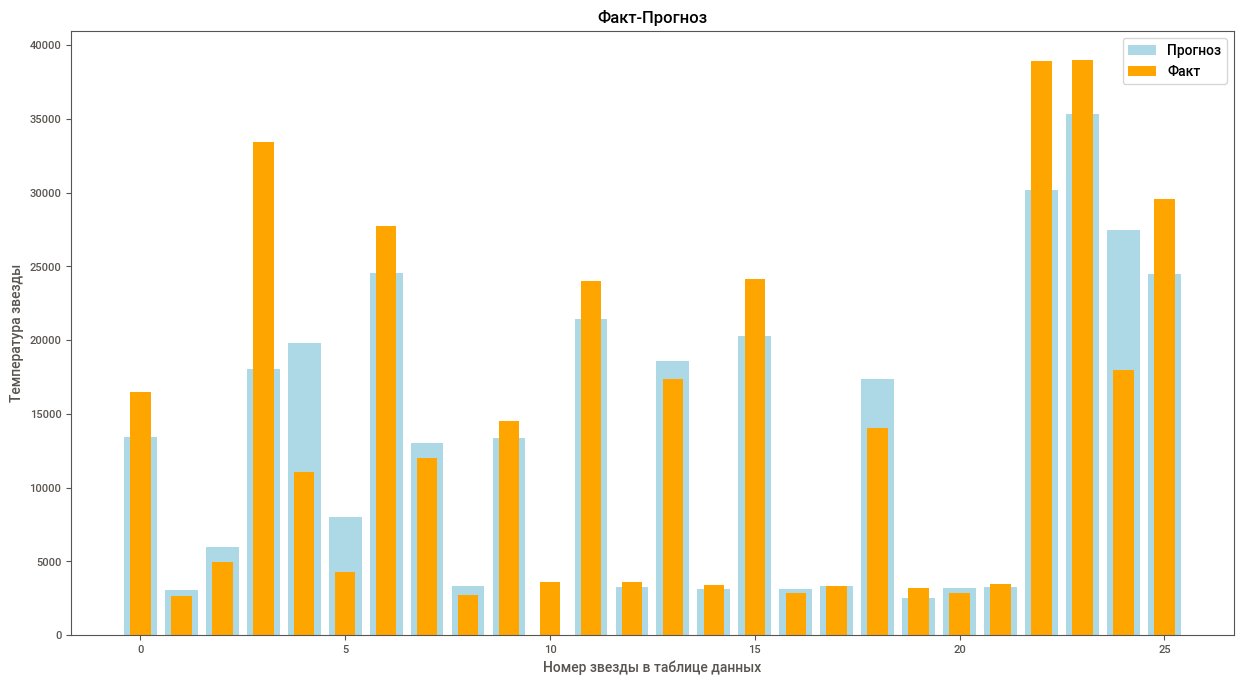

график "Факт-Прогноз" по результатам улучшенной нейросети:


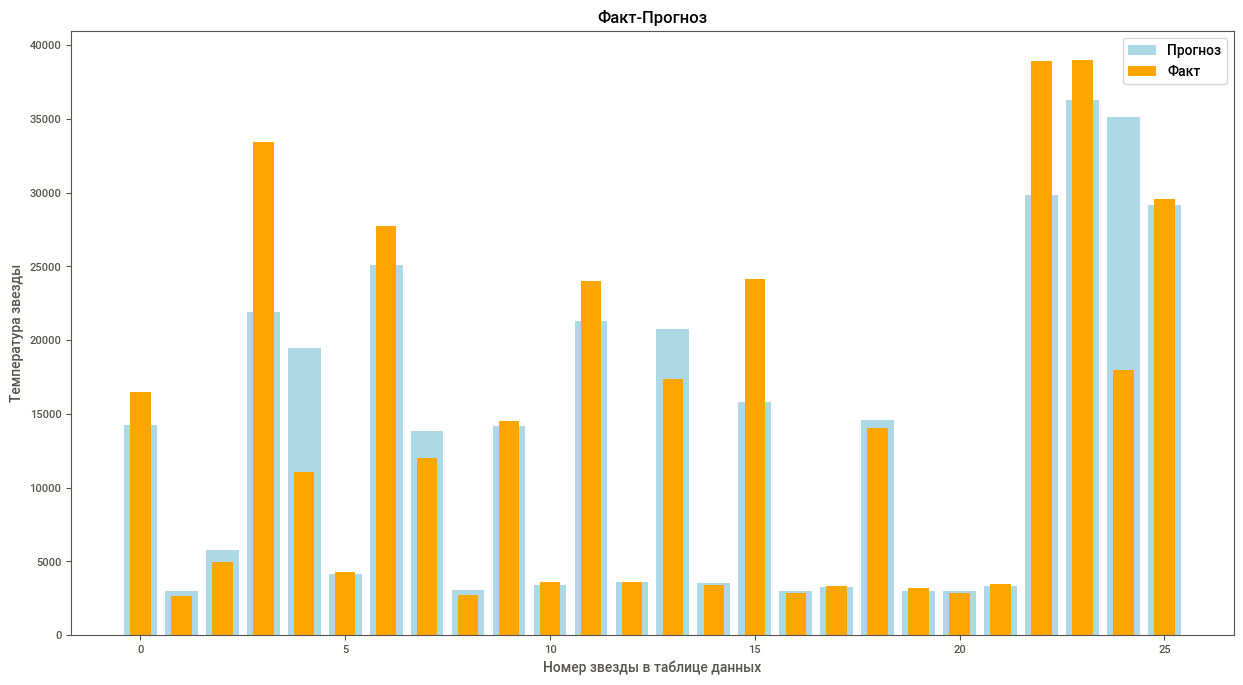

In [53]:
#график "Факт-Прогноз" по результатам базовой нейросети
print('график "Факт-Прогноз" по результатам базовой нейросети:')
predictions_graph(base_preds)

#график "Факт-Прогноз" по результатам улучшенной нейросети
print('график "Факт-Прогноз" по результатам улучшенной нейросети:')
predictions_graph(improved_preds)

**Базовая модель хорошо предсказывает температуру для звезд с низкой температурой, но менее точно делает это для звезд с более высокой температурой. График показывает, что улучшенная модель стала значительно лучше прогнозировать температуру для звезд с низкими значениями и более точно предсказывать для звезд с более высокой температурой. RMSE выбранной модели не превышает 4500: условия задачи выполнены**